In [ ]:
# !pip install Pillow
# !pip install tf-nightly
# !pip install pandas
# !pip install ibm_boto3
# !pip install botocore
# !pip install ibm-cos-sdk
# !pip install imageio
# !pip install seaborn
# !pip install plotly
# !pip install tensorflow_hub
# !pip install tensorflow-model-optimization
# !pip install edge_ai_model_mgmt
# !pip install edgeaimodelmgmt


In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np # linear algebra
import pandas as pd
# import cv2
import os, types
import math
import imageio
import seaborn as sns
from glob import glob
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image
import PIL
from PIL import Image
import time


from botocore.client import Config
import ibm_boto3
import zipfile
import shutil

import requests
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns
import plotly.express as px
from IPython.display import SVG
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

%matplotlib inline

In [3]:
import tempfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.applications import VGG16,inception_v3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
from tensorflow.keras.layers import Input, Lambda,Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                                    Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
                                    LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape,\
                                    Conv2DTranspose, LeakyReLU, Conv1D, AveragePooling1D, MaxPooling1D

from tensorflow.keras.models import load_model
import tensorflow_hub as hub


In [4]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.1
Hub version: 0.12.0
GPU is NOT AVAILABLE


2022-03-31 17:04:08.934657: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [5]:
bucket_name = 'gurvsin3-visualrecognition'
object_key = 'fire_dataset.zip'

DATA_DIR = os.path.join(os.path.abspath(os.path.pardir),'data')
RESULTS_DIR = os.path.join('../results/fire_detection', 'simple')
dataZip = os.path.join(DATA_DIR, object_key)
dataset_dir = pathlib.Path(DATA_DIR+'/fire_dataset')

BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

In [6]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IBM_API_KEY_ID': '816HFeHbtI_WiIlkFTaAO61vld7bM7nDB08U7MpaVHNm',
    'COS_SERVICE_CRN': 'crn:v1:bluemix:public:iam-identity::a/2c303e22de2b34062121bab41b176b1b::serviceid:ServiceId-3152b935-e74b-4e7d-8460-6e9d56d166e8',
    'ENDPOINT': 'https://s3.jp-tok.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/identity/token',
    'BUCKET': 'myml-donotdelete-pr-zhsoop3fasxh7h',
    'FILE': 'fire_dataset.zip'
}


In [7]:
def loadDataFromCOS(bucket_name, object_key):
    
    def __iter__(self): return 0

    cos_cli = ibm_boto3.client(service_name='s3',
        ibm_api_key_id=credentials_1["IBM_API_KEY_ID"],
        ibm_service_instance_id=credentials_1["COS_SERVICE_CRN"],
        ibm_auth_endpoint=credentials_1["IBM_AUTH_ENDPOINT"],
        config=Config(signature_version="oauth"),
        endpoint_url=credentials_1["ENDPOINT"]
    )

    # Your data file was loaded into a botocore.response.StreamingBody object.
    # Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
    # ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
    # pandas documentation: http://pandas.pydata.org/
    streaming_body_1 = cos_cli.get_object(Bucket=bucket_name, Key=object_key)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 
        
    f = open(object_key, 'wb')
    f.write(streaming_body_1.read())
    

In [8]:
def unzip_dataset(file_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

In [9]:
def load_dataset():
    if os.path.exists(object_key):
        print('Data ZIP file exists')
        if(os.path.isdir(DATA_DIR)):
            print('Dataset unziped Exists')
        else:
            print('Unzip required..')
            unzip_dataset(object_key)
    else:
        print('No Data')
        loadDataFromCOS(bucket_name, object_key)
        unzip_dataset(object_key)

load_dataset()


Data ZIP file exists
Dataset unziped Exists


In [ ]:
# UNCOMMENT ONLY TO REMOVE FILES
# shutil.rmtree(data_dir)

In [10]:
# data_dir = pathlib.Path(data_dir_path+'/fire_dataset')
jpg_image_count = len(list(dataset_dir.glob('*/*.jpg')))
png_image_count = len(list(dataset_dir.glob('*/*.png')))
print(jpg_image_count, png_image_count)

624 1012


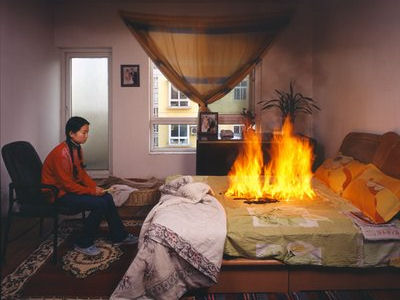

In [11]:
fire_images = list(dataset_dir.glob('fire/*'))
PIL.Image.open(str(fire_images[0]))

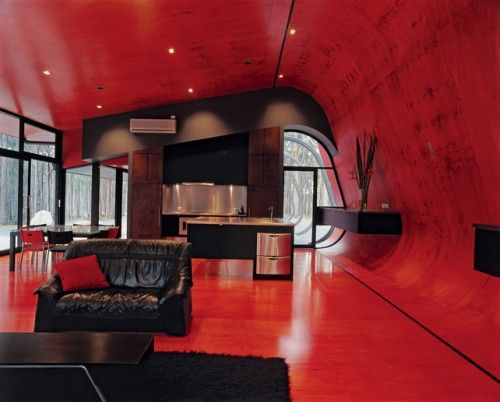

In [12]:
non_fire_images = list(dataset_dir.glob('non_fire/*'))
PIL.Image.open(str(non_fire_images[0]))

In [13]:
def build_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        validation_split=.20,
        subset=subset,
        label_mode="categorical",
        # Seed needs to provided when using validation_split and shuffle = True.
        # A fixed seed is used so that the validation set is stable across runs.
        seed=123,
        image_size=IMAGE_SIZE,
        batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

# normalization_layer = tf.keras.layers.Rescaling(1. / 255)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)

preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True
if do_data_augmentation:
    preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomRotation(40))
    preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0, 0.2))
    preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
    preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
      tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
    
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))


Found 1650 files belonging to 2 classes.
Using 1320 files for training.


2022-03-31 17:04:28.997156: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1650 files belonging to 2 classes.
Using 330 files for validation.


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:

model = Sequential([
    layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names)),
    layers.Activation('softmax')
])

# model = models.Sequential()
# model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=IMAGE_SIZE + (3,), padding='same'))
# model.add(layers.MaxPool2D(2, 2))
# model.add(layers.Conv2D(64, (5, 5), activation='relu'))
# model.add(layers.MaxPool2D(2, 2))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(len(class_names)))
# model.add(layers.Activation('softmax'))

# model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)            

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(lr=.00015),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model.compile(
#   optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
#   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
#   metrics=['accuracy'])

In [16]:
Callback_Stop_Early = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,mode='auto')

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = model.fit(
    train_ds,
    epochs=25, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    callbacks=[Callback_Stop_Early],
    validation_steps=validation_steps).history

2022-03-31 17:04:53.818584: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/25
41/41 [==============================] - 65s 2s/step - loss: 0.7453 - accuracy: 0.6461 - val_loss: 0.5822 - val_accuracy: 0.7000
Epoch 2/25
41/41 [==============================] - 66s 2s/step - loss: 0.4613 - accuracy: 0.7855 - val_loss: 0.3489 - val_accuracy: 0.8531
Epoch 3/25
41/41 [==============================] - 64s 2s/step - loss: 0.3748 - accuracy: 0.8332 - val_loss: 0.2654 - val_accuracy: 0.8906
Epoch 4/25
41/41 [==============================] - 63s 2s/step - loss: 0.3394 - accuracy: 0.8709 - val_loss: 0.3376 - val_accuracy: 0.8625
Epoch 5/25
41/41 [==============================] - 64s 2s/step - loss: 0.3175 - accuracy: 0.8744 - val_loss: 0.2812 - val_accuracy: 0.8813
Epoch 6/25
41/41 [==============================] - 65s 2s/step - loss: 0.2745 - accuracy: 0.8973 - val_loss: 0.2360 - val_accuracy: 0.9000
Epoch 7/25
41/41 [==============================] - 66s 2s/step - loss: 0.2931 - accuracy: 0.8904 - val_loss: 0.2529 - val_accuracy: 0.9062
Epoch 8/25
41/41 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


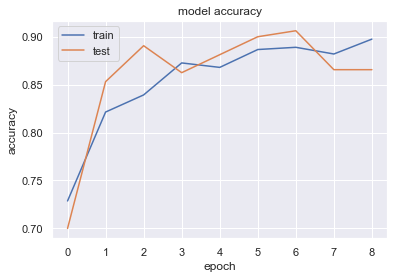

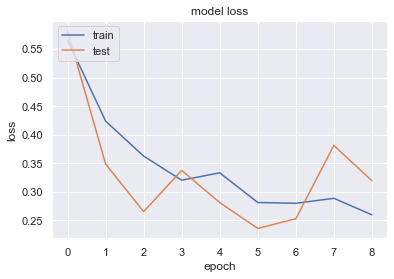

In [17]:
def plot_graph(history):
    print(history.keys())
    sns.set()
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_graph(history)

In [43]:
model_save_path = os.path.join(RESULTS_DIR, 'fire_simple.h5')
# model_save_path = '../results/fire_detection/tfhub/fire_tfhub.h5'
# model_save_path = '../results/fire_detection/colab'
print(model_save_path)

../results/fire_detection/research/fire_simple.h5


In [44]:
model.save(model_save_path)

In [45]:
model = load_model(model_save_path)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)            

In [22]:
def convert_to_lite(model):
    optimize_lite_model = False 
    num_calibration_examples = 60 
    representative_dataset = None
    if optimize_lite_model and num_calibration_examples:
      # Use a bounded number of training examples without labels for calibration.
      # TFLiteConverter expects a list of input tensors, each with batch size 1.
        representative_dataset = lambda: itertools.islice(
            ([image[None, ...]] for batch, _ in train_ds for image in batch),
            num_calibration_examples)

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimize_lite_model:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        if representative_dataset:  # This is optional, see above.
            converter.representative_dataset = representative_dataset
    lite_model_content = converter.convert()

    with open(RESULTS_DIR+'/model.tflite', "wb") as f:
        f.write(lite_model_content)
    print("Wrote %sTFLite model of %d bytes." %
          ("optimized " if optimize_lite_model else "", len(lite_model_content)))

convert_to_lite(model)

2022-03-31 17:15:53.059836: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/26/41vtvst14s1g_ylqwqct8qr80000gn/T/tmps98e54uo/assets


2022-03-31 17:15:54.386664: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-03-31 17:15:54.386760: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-31 17:15:54.391024: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.



Wrote TFLite model of 14550384 bytes.


2022-03-31 17:15:55.106777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-03-31 17:15:55.106795: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


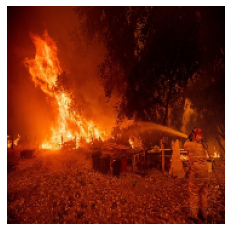

(1, 180, 180, 3)
prediction_scores:  [[0.9929565  0.00704351]]
True label: fire
Predicted label: fire


In [23]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

print(np.expand_dims(image, axis=0).shape)

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
print('prediction_scores: ', prediction_scores)
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

# loss, acc = model.evaluate(val_ds, verbose=2)

57344/54770 [===============================] - 0s 0us/step
../data/datasets/test_img


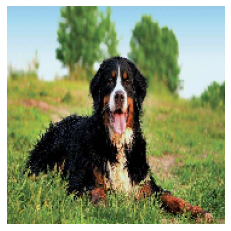

In [24]:
!rm -rf ../data/datasets/test_img
class_names = ['fire', 'non_fire']

# test_img_url = 'https://climate.esa.int/media/images/Fire-CCI-banner_1.2e16d0ba.fill-600x314-c100.format-jpeg.jpg'
# test_img_url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/small-kitchen-1572367025.png'
# test_img_url = 'https://images.indianexpress.com/2021/03/Pune-fire-1.jpg'
# test_img_url = 'https://i.insider.com/56843d15dd0895dc648b47fd?width=1000&format=jpeg&auto=webp'
# test_img_url = 'https://charlestonfire.org/images/public-news/large/news-1501509679.jpg' 
# test_img_url = 'https://cf.ltkcdn.net/safety/images/std/116578-232x317r1-Kitchenfireprevention.jpg' # No_Fire
# test_img_url ='https://www.kutchina.com/wp-content/uploads/2020/07/straight-line-2-min-600x350.jpg' # No_Fire
# test_img_url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/kitchen-ideas-wall-display-1603743563.jpg'
# test_img_url = 'https://media.springernature.com/lw725/springer-cms/rest/v1/content/19831396/data/v1' # False Negative
# test_img_url = 'https://media-exp1.licdn.com/dms/image/C4D1BAQGrF7AoQDBPXQ/company-background_10000/0/1631550860606?e=2147483647&v=beta&t=0MXoiDfXevwDLrZ8ZHFEXxlcS0T_iyMShpgHlunLMQo'
# test_img_url = 'https://www.thespruce.com/thmb/XMuqYgCjvYclSkDrm7ALrwnoXw8=/1777x1333/smart/filters:no_upscale()/fire-pit-backyard-ideas-4177680-hero-4b2d98b9204b4cd4bdb534a5a9b106f4.jpg' # False Negative

test_img_url = 'https://cdn.britannica.com/49/161649-050-3F458ECF/Bernese-mountain-dog-grass.jpg?q=60'

test_img_path = tf.keras.utils.get_file('test_img', origin=test_img_url, cache_dir='../data')
# test_img_path = '/Users/gurvindersingh/Downloads/fire.jpeg'

# test_img_path = '../data/fire_dataset/non_fire/10.jpg'

print(test_img_path)

img = keras.preprocessing.image.load_img(
    test_img_path, target_size=IMAGE_SIZE
)

plt.imshow(img)
plt.axis('off')
plt.show()

In [25]:
# image = Image.open(test_img_path).convert('RGB').resize(IMAGE_SIZE, Image.ANTIALIAS)
# img_array = np.float32(image) / 255
img_array = keras.preprocessing.image.img_to_array(img) / 255
# img_array = (np.float32(image) - 123) / 123
# img_array = tf.expand_dims(img_array, 0) # Create a batch
# img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(np.expand_dims(img_array, axis=0))
print("predictions: ", predictions)
score = tf.nn.softmax(predictions[0])
predicted_index = np.argmax(predictions)
score = tf.nn.softmax(predictions[0])

# print('score: ', score)
print('Class: ', np.argmax(score))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

predictions:  [[4.0599814e-04 9.9959403e-01]]
Class:  1
This image most likely belongs to non_fire with a 73.09 percent confidence.


In [26]:
# Load the TFLite model and allocate tensors.

# RESULTS_DIR = '../results/fire_detection/research'


interpreter = tf.lite.Interpreter(model_path=RESULTS_DIR+'/model.tflite')
interpreter.allocate_tensors()

_, height, width, _ = interpreter.get_input_details()[0]['shape']
print('width: ', width, ', height: ', height)
input_index = interpreter.get_input_details()[0]["index"]
output_details = interpreter.get_output_details()[0]
output_index = output_details["index"]

width:  180 , height:  180


In [27]:
def set_input_tensor(interpreter, image):
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

def classify_image(interpreter, image, top_k=1):
    """Returns a sorted array of classification results."""
#     set_input_tensor(interpreter, image)
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()
    
#     output = np.squeeze(interpreter.get_tensor(output_index['index']))
    output = interpreter.tensor(output_index)
#     digit = np.argmax(output()[0])
#     confidence = np.max(output()[0])
    score = (np.exp(output()).T / np.exp(output()).sum(axis=-1)).T
    print('score', score)
    # If the model is quantized (uint8 data), then dequantize the results
    if output_details['dtype'] == np.uint8:
        scale, zero_point = output_details['quantization']
        output = scale * (output - zero_point)
        print('quantized model output: >> ', output)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [28]:
image = Image.open(test_img_path).convert('RGB').resize(IMAGE_SIZE, Image.ANTIALIAS)
img_array = np.float32(image) / 255

img_array = np.expand_dims(img_array, axis=0)

print(img_array.shape)

result = classify_image(interpreter, img_array)


(1, 180, 180, 3)
score [[0.26922318 0.73077685]]
This image most likely belongs to non_fire with a 73.08 percent confidence.


In [29]:
import tensorflow_model_optimization as tfmot
from edgeaimodelmgmt.ode.tf_pruner import TfPruner
from edgeaimodelmgmt.ode.tf_quantizer import TfQuantizer
from modelmgmt.fingerprinting.model_fingerprint import ModelFingerprint
from modelmgmt.fingerprinting.fingerprint import Fingerprint
from modelmgmt.models.keras_model import KerasModel

In [30]:
x_train = []
y_train = []
x_test = []
y_test = []

for i, (image, label) in enumerate(train_ds.unbatch().take(1320)):
    x_train.append(image.numpy())
    y_train.append(label.numpy())
    
for i, (image, label) in enumerate(val_ds.unbatch().take(330)):
    x_test.append(image.numpy())
    y_test.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1320, 180, 180, 3)
(1320, 2)
(330, 180, 180, 3)
(330, 2)


In [31]:
q = TfQuantizer(model)
q_aware_model, err = q.quantize(np.int8, 8, x_train, y_train, x_test, y_test, include_biases=True, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], validation_data=None)

# Evaluate the model
if not err:
    loss, acc = q_aware_model.evaluate(x_test,  y_test, verbose=2)
    print("Quant trained model, accuracy: {:5.2f}%".format(100*acc))
else:
    print("Could not quantize the model...")
    exit() # terminate execution as we cannot continue with the script...

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 180, 180, 3)       3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 180, 180, 16)      483       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 90, 90, 16)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 88, 88, 32)        4707      
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 44, 44, 32)        1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 42, 42, 64)        18627     
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 21, 21, 64)       

In [32]:
RESULTS_DIR = os.path.join('../results/fire_detection', 'research')

optimize_lite_model = False 
num_calibration_examples = 60 
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
    representative_dataset = lambda: itertools.islice(
        ([image[None, ...]] for batch, _ in train_ds for image in batch),
        num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
if optimize_lite_model:
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if representative_dataset:  # This is optional, see above.
        converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(RESULTS_DIR+'/qaware.tflite', "wb") as f:
    f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

INFO:tensorflow:Assets written to: /var/folders/26/41vtvst14s1g_ylqwqct8qr80000gn/T/tmpull6xtyp/assets


INFO:tensorflow:Assets written to: /var/folders/26/41vtvst14s1g_ylqwqct8qr80000gn/T/tmpull6xtyp/assets
2022-03-31 17:23:01.151396: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-03-31 17:23:01.151571: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-31 17:23:01.154576: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.



Wrote TFLite model of 14656896 bytes.


2022-03-31 17:23:02.913513: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-03-31 17:23:02.913540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


In [33]:

quantized_model, err = q.post_training_quantization(q_aware_model, tf.int8, x_test[:200])

if not err:
    q.save_quantized_model(quantized_model, '{}/post_quant.tflite'.format(RESULTS_DIR))
else:
    print('Could not quantize the model...')
    exit()

INFO:tensorflow:Assets written to: /var/folders/26/41vtvst14s1g_ylqwqct8qr80000gn/T/tmpuzf8ikn7/assets


INFO:tensorflow:Assets written to: /var/folders/26/41vtvst14s1g_ylqwqct8qr80000gn/T/tmpuzf8ikn7/assets
2022-03-31 17:23:14.258730: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-03-31 17:23:14.258834: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-31 17:23:14.261746: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-03-31 17:23:15.944631: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-03-31 17:23:15.944661: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


INFO:tensorflow:Assets written to: /var/folders/26/41vtvst14s1g_ylqwqct8qr80000gn/T/tmpnoppo4fu/assets


INFO:tensorflow:Assets written to: /var/folders/26/41vtvst14s1g_ylqwqct8qr80000gn/T/tmpnoppo4fu/assets
2022-03-31 17:23:18.715836: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-03-31 17:23:18.715974: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-31 17:23:18.718119: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 180, 180, 3)       3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 180, 180, 16)      483       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 90, 90, 16)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 88, 88, 32)        4707      
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 44, 44, 32)        1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 42, 42, 64)        18627     
_________________________________________________________________
quant_max_pooling2d_2 (Quant (None, 21, 21, 64)       

2022-03-31 17:23:19.569099: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-03-31 17:23:19.569124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


In [34]:
headers = {'X-IBM-Client-Id': '4ada90b8-88ec-4ef5-88a5-2c15df158069',
           'X-IBM-Client-Secret':'V0hT7sL5yN5cK5sG3jF5fF5cL0rR0kC8lX4oA7yM8gC5rC4hB5'}

In [35]:
dsfilename = 'fire.pickle'

with open(dsfilename, 'wb') as file:
    pickle.dump(x_train, file)

In [36]:
kmodel = KerasModel(keras_model=model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)            

In [38]:
mf = ModelFingerprint()
# fire_fp = mf.generate_finger_print(x_train, kmodel, partial_activations=0.2)
fire_fp = mf.generate_finger_print(x_train, kmodel, logits_only=False)

Epoch 1/10
6/6 [==============================] - 80s 11s/step - loss: 0.2255 - val_loss: 0.1919
Epoch 2/10
6/6 [==============================] - 47s 8s/step - loss: 0.1075 - val_loss: 0.0052
Epoch 3/10
6/6 [==============================] - 40s 7s/step - loss: 0.0053 - val_loss: 0.0052
Epoch 4/10
6/6 [==============================] - 36s 7s/step - loss: 0.0053 - val_loss: 0.0052
Epoch 5/10
6/6 [==============================] - 36s 7s/step - loss: 0.0053 - val_loss: 0.0052
Epoch 6/10
6/6 [==============================] - 34s 6s/step - loss: 0.0053 - val_loss: 0.0052
Epoch 7/10
6/6 [==============================] - 37s 7s/step - loss: 0.0052 - val_loss: 0.0052
Epoch 8/10
6/6 [==============================] - 28s 5s/step - loss: 0.0052 - val_loss: 0.0052
Epoch 9/10
6/6 [==============================] - 27s 5s/step - loss: 0.0053 - val_loss: 0.0052
Epoch 10/10
6/6 [==============================] - 22s 4s/step - loss: 0.0052 - val_loss: 0.0052
Finished calculating sketch and L2 rec

6/6 [==============================] - 0s 13ms/step - loss: 0.0655 - val_loss: 0.0645
Epoch 10/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0643 - val_loss: 0.0627
Finished calculating sketch and L2 reconstruction error for layer 8
Epoch 1/10
6/6 [==============================] - 1s 42ms/step - loss: 0.2756 - val_loss: 0.2656
Epoch 2/10
6/6 [==============================] - 0s 13ms/step - loss: 0.2603 - val_loss: 0.2319
Epoch 3/10
6/6 [==============================] - 0s 14ms/step - loss: 0.2209 - val_loss: 0.1753
Epoch 4/10
6/6 [==============================] - 0s 13ms/step - loss: 0.1658 - val_loss: 0.1248
Epoch 5/10
6/6 [==============================] - 0s 13ms/step - loss: 0.1142 - val_loss: 0.0915
Epoch 6/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0865 - val_loss: 0.0793
Epoch 7/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0771 - val_loss: 0.0733
Epoch 8/10
6/6 [==============================] - 0s 13ms/step - loss

In [39]:
path = RESULTS_DIR+'/fire_fp.pickle'
fire_fp.save(path)

In [40]:
print(np.asarray(x_test[:50]).shape)
# print(np.asarray(np.expand_dims(img_array, axis=0)).shape)
print(np.asarray(img_array).shape)

(50, 180, 180, 3)
(1, 180, 180, 3)


In [42]:
# out, score = mf.outlier_detection(mnist_fp, (x_test.astype('float32') / 255.)[:100], model)
out, score = mf.outlier_detection(fire_fp, x_test[:50], kmodel, verbose=False, logits_only=False)
score

0.78

In [ ]:
url = 'https://api.ibm.com/edgeai/run/modelmgmt/generate_fingerprint' # your url may differ. change as neccessary

data = {'partial_activations': 0.2}

multiple_files = [
    ('dataset', ('fire.pickle', open(dsfilename, 'rb'), 'file/pickle')),
    ('model', ('fire_simple2.h5', open('fire_simple2.h5', 'rb'), 'file/h5'))]

r = requests.post(url, data=data, files=multiple_files, headers=headers, verify=False)

In [ ]:
r.text

In [ ]:
r.json()
task_id = r.json()['task_id']

In [ ]:
print(task_id)

In [ ]:
url = 'https://api.ibm.com/edgeai/run/modelmgmt/status/{}'.format(task_id)

r = requests.get(url, headers=headers, verify=False)
r.json()  

In [ ]:
url = 'https://api.ibm.com/edgeai/run/modelmgmt/get_result'

payload = {'task_id': task_id}
r = requests.post(url, json=payload, headers=headers,verify=False)

In [ ]:
r

In [ ]:
saved_fingerprint = 'fire_fingerprint.zip'
with open(saved_fingerprint, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

In [ ]:
x_test = x_test[:10]
print(x_test.shape)
with open('fire_test.pickle', 'wb') as file:
    pickle.dump(x_test, file)

In [ ]:
len(model.layers)

In [ ]:
num_layers = 9
activation_mapping = True

url = 'https://api.ibm.com/edgeai/run/modelmgmt/outlier_detection'

payload = {'num_layers': num_layers, 'activation_mapping': activation_mapping}

multiple_files = [
    ('dataset', ('fire_test.pickle', open('fire_test.pickle', 'rb'), 'file/pickle')),
    ('model', ('fire_simple2.h5', open('fire_simple2.h5', 'rb'), 'file/h5')),
    ('fingerprint', (saved_fingerprint, open(saved_fingerprint, 'rb'), 'file/zip'))]


r = requests.post(url,  data=payload, files=multiple_files, headers=headers, verify=False)

In [ ]:
r

In [ ]:
score = r.json()['score']
print(score)